In [11]:
import pandas as pd

# 读取数据
df = pd.read_csv('交易复盘_时间优化版.csv')

# 定义需要统计的分位数 (10% 到 90%，以及中位数)
percentiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 按方向分组并计算分位数
stats = df.groupby('方向')['错失空间%'].quantile(percentiles).unstack()

# 补充最小值、最大值和平均值
stats['min'] = df.groupby('方向')['错失空间%'].min()
stats['max'] = df.groupby('方向')['错失空间%'].max()
stats['mean'] = df.groupby('方向')['错失空间%'].mean()

# 整理列顺序，方便查看
columns_order = ['min'] + percentiles + ['max', 'mean']
stats = stats[columns_order]

# 重命名索引和列名以显示中文
stats.index = stats.index.map({'B': '买入 (Buy)', 'S': '卖出 (Sell)'})
stats.columns = [f'{int(c*100)}%' if isinstance(c, float) else c for c in stats.columns]

print("--- 买入/卖出 错失空间分布统计表 ---")
print(stats.round(2)) # 保留两位小数

--- 买入/卖出 错失空间分布统计表 ---
           min    5%   10%   20%   30%   40%   50%   60%   70%   80%   90%  \
方向                                                                           
买入 (Buy)   0.0  0.00  0.00  0.21  0.53  0.92  1.50  2.16  3.09  4.76  8.97   
卖出 (Sell)  0.0  0.09  0.26  0.61  0.92  1.46  1.98  2.65  3.35  4.37  6.46   

              max  mean  
方向                       
买入 (Buy)    50.05  3.49  
卖出 (Sell)  431.36  7.13  



--- B 方向统计 ---
最短等待分位数:
 count     88.000000
mean      17.079545
std       46.326731
min        0.000000
10%        0.000000
25%        1.750000
50%        2.000000
75%        8.000000
90%       28.000000
max      256.000000
Name: shortest_wait_m, dtype: float64
最佳等待分位数:
 count     88.000000
mean     120.329545
std      120.667370
min        0.000000
10%        0.000000
25%       17.500000
50%       84.000000
75%      212.500000
90%      313.600000
max      396.000000
Name: best_wait_m, dtype: float64

--- S 方向统计 ---
最短等待分位数:
 count     96.000000
mean      19.500000
std       60.664218
min        0.000000
10%        1.000000
25%        2.000000
50%        2.000000
75%        6.250000
90%       43.000000
max      478.000000
Name: shortest_wait_m, dtype: float64
最佳等待分位数:
 count     96.000000
mean     145.500000
std      123.343508
min        0.000000
10%        9.500000
25%       30.000000
50%      118.000000
75%      252.500000
90%      306.500000
max      532.000000
Name: best_wait_m,

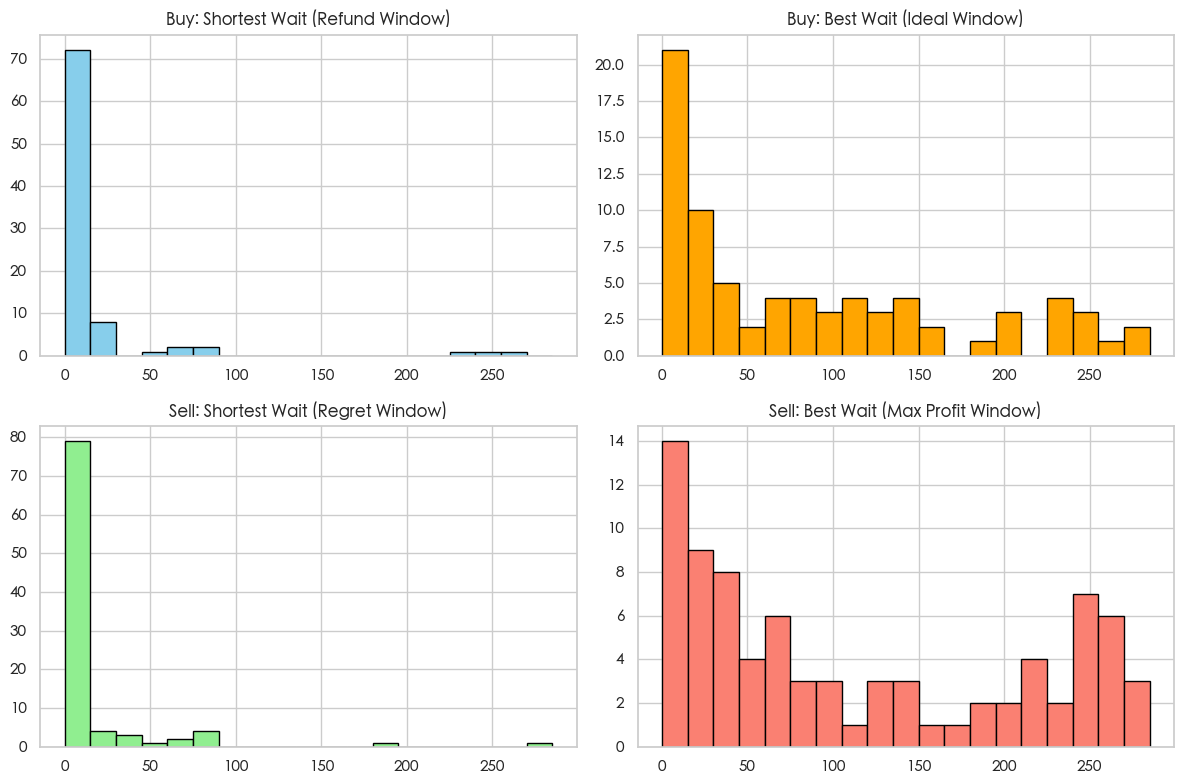

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- 核心修复代码 ---
plt.rcParams['font.sans-serif'] = ['Droid Sans Fallback'] # 或者使用您系统有的其他中文字体
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示为方块的问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 
# 或者
plt.rcParams['font.sans-serif'] = ['Heiti TC'] # 苹果黑体

# 1. 读取数据
df = pd.read_csv('交易复盘_时间优化版.csv')

# 2. 时间解析函数
def parse_time_str(s):
    if pd.isna(s): return 0
    s = str(s)
    total_m = 0
    h = re.search(r'(\d+)h', s)
    m = re.search(r'(\d+)m', s)
    if h: total_m += int(h.group(1)) * 60
    if m: total_m += int(m.group(1))
    return total_m

# 解析 '最佳等待'
df['best_wait_m'] = df['最佳等待'].apply(parse_time_str)

# 解析 '最短等待' (处理 '同最佳' 的情况)
def parse_shortest(row):
    s = str(row['最短等待'])
    if '同最佳' in s:
        return row['best_wait_m']
    return parse_time_str(s)

df['shortest_wait_m'] = df.apply(parse_shortest, axis=1)

# 3. 统计分位数
def get_stats(direction_code):
    sub = df[df['方向'] == direction_code]
    print(f"\n--- {direction_code} 方向统计 ---")
    print("最短等待分位数:\n", sub['shortest_wait_m'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))
    print("最佳等待分位数:\n", sub['best_wait_m'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

get_stats('B') # 买入
get_stats('S') # 卖出

# 4. 画图
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 设置统一的直方图参数
bins = range(0, 300, 15) # 0到300分钟，每15分钟一档

# 买入 - 最短
axes[0,0].hist(df[df['方向']=='B']['shortest_wait_m'], bins=bins, color='skyblue', edgecolor='black')
axes[0,0].set_title('Buy: Shortest Wait (Refund Window)')

# 买入 - 最佳
axes[0,1].hist(df[df['方向']=='B']['best_wait_m'], bins=bins, color='orange', edgecolor='black')
axes[0,1].set_title('Buy: Best Wait (Ideal Window)')

# 卖出 - 最短
axes[1,0].hist(df[df['方向']=='S']['shortest_wait_m'], bins=bins, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Sell: Shortest Wait (Regret Window)')

# 卖出 - 最佳
axes[1,1].hist(df[df['方向']=='S']['best_wait_m'], bins=bins, color='salmon', edgecolor='black')
axes[1,1].set_title('Sell: Best Wait (Max Profit Window)')

plt.tight_layout()
plt.show()